# Project 3.  

In [ ]:
import sys
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy.linalg as LA
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#file_path = 'polluteddata.csv'
file_path = '/content/drive/MyDrive/Applications Programming/Project 3/polluteddata.csv'
data = pd.read_csv(file_path,header=None)
polluteddata = data.to_numpy()

## Part I – Defining Our Power Method & Interval Testing Function

In [ ]:
#power method
def power_method(matrix, max_iterations=1000, tolerance=1e-6):
    n = matrix.shape[0]
    b = np.random.rand(n)
    b = b / np.linalg.norm(b)

    eigenvalue_old = 0
    for i in range(max_iterations):
        b = np.dot(matrix, b)
        b_norm = np.linalg.norm(b)
        b = b / b_norm
        eigenvalue = np.dot(b.T, np.dot(matrix, b))

        if abs(eigenvalue - eigenvalue_old) < tolerance:
            break
        eigenvalue_old = eigenvalue

    return eigenvalue

# For a given window_size, calculates the max eigenvalues (using power_method) of the covariance matrix for every increment that the window slides
def find_intervals(data,window_size, shift = 0):
    eigenvalues = []

    for start in range(shift, data.shape[0] - window_size):
        interval_data = data[start:start + window_size]
        cov_matrix = np.cov(interval_data, rowvar=False)
        max_eigenvalue = power_method(cov_matrix)
        eigenvalues.append((start, start + window_size, max_eigenvalue))

    #returns array of tuples (start,end,max_eigenvalue) for all intervals that fit
    eigenvalues = np.array(eigenvalues)
    return eigenvalues

## Part II – Plotting Results for Different Windows

In [ ]:
pdata = data.iloc[:, 1:] #our polluted data without differencing (want to start at 1 to avoid first column)
pdata_diff = pdata.diff(axis=1).iloc[:, 1:] #our polluted data with differencing

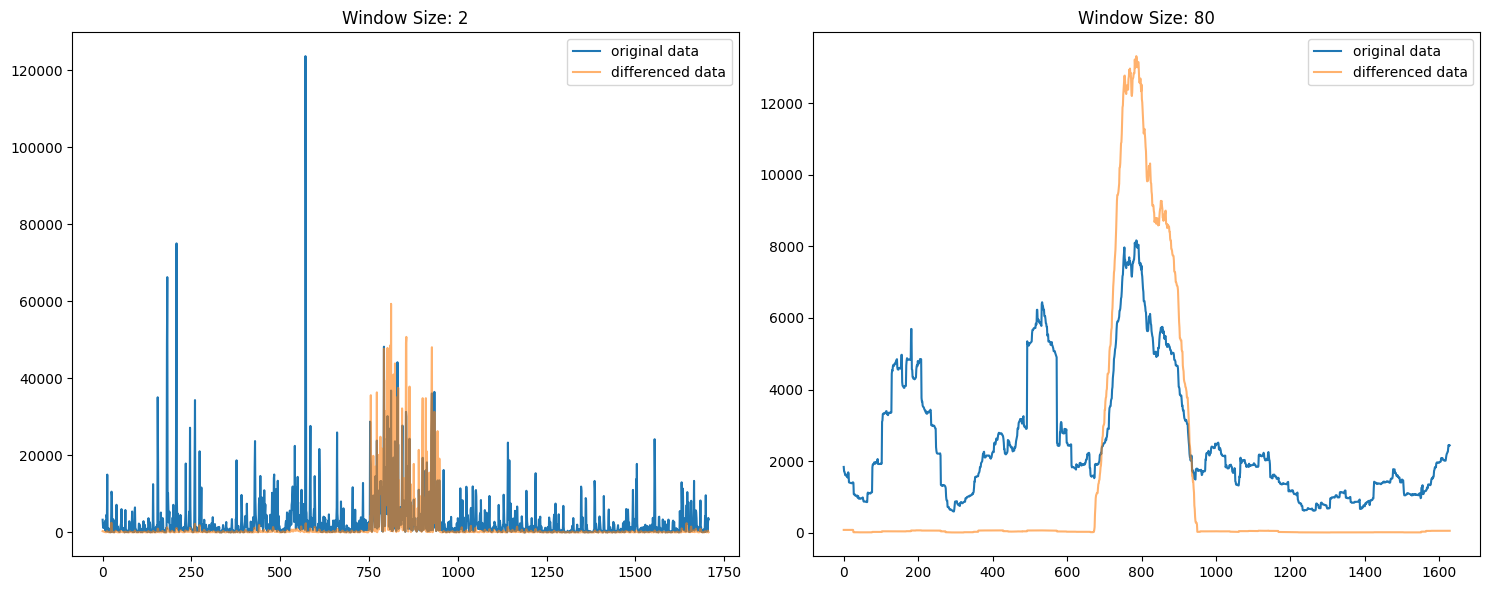

In [ ]:
#creates plot over [start,end] interval of largest eigenvalues in each period
def single_window(data,start,end,window_size,label,opacity=1):
    results = find_intervals(data,window_size)
    left_edge = [interval[0] for interval in results]
    value = [interval[2] for interval in results]
    plt.plot(left_edge[start:end],value[start:end],label=label,alpha=opacity)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

#Window Size 2
plt.sca(ax1)
single_window(data=pdata, start=0, end=1709, window_size=2, label='original data')
single_window(data=pdata_diff, start=0, end=1709, window_size=2, label='differenced data', opacity=0.6)
ax1.legend()
ax1.set_title("Window Size: 2")

#Window Size 80
plt.sca(ax2)
single_window(data=pdata, start=0, end=1709, window_size=80, label='original data')
single_window(data=pdata_diff, start=0, end=1709, window_size=80, label='differenced data', opacity=0.6)
ax2.legend()
ax2.set_title("Window Size: 80")

plt.tight_layout()
plt.show()

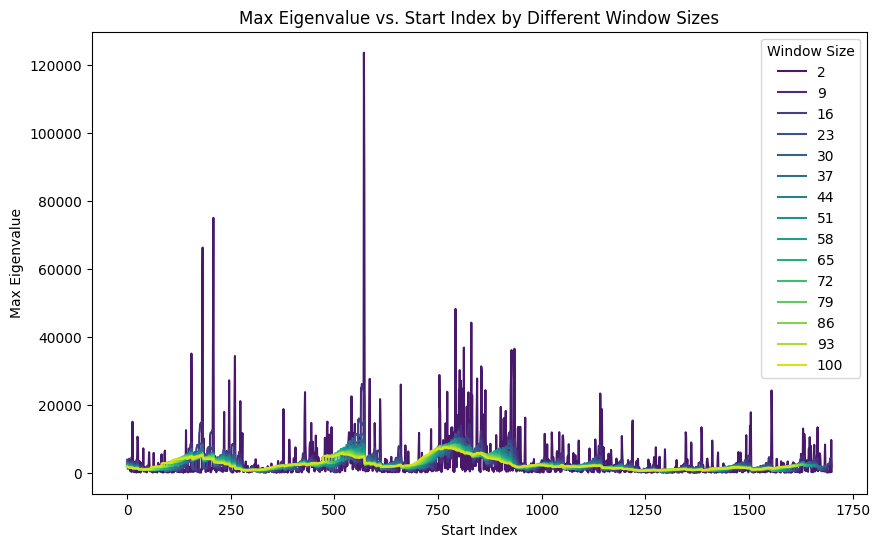

In [ ]:
start = 0
end = 1700
window_sizes = np.linspace(2, 100, 15)  #10 windows from 2 to 50

data = {
    "Start Index": [],
    "Max Eigenvalue": [],
    "Window Size": []
}

#for each window size do a single_window plot
for window_size in window_sizes:
    results = np.array(find_intervals(pdata,window_size=int(window_size)))
    start_indices = results[:end-start, 0]
    eigenvalues = results[:end-start, 2]

    data["Start Index"].extend(start_indices)
    data["Max Eigenvalue"].extend(eigenvalues)
    data["Window Size"].extend([int(window_size)] * len(start_indices))  # Use integer window size to avoid floating point error

df = pd.DataFrame(data)
df["Window Size"] = df["Window Size"].astype(str)  # Convert to string for proper labeling

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Start Index", y="Max Eigenvalue", hue="Window Size", palette="viridis")
plt.title("Max Eigenvalue vs. Start Index by Different Window Sizes")
plt.show()


## Part III – Choosing Final Interval

In [ ]:
results_temp = find_intervals(pdata_diff,2)
diff_eigenvalues_temp = np.abs(np.diff(results_temp[:, 2])) # Getting the diff_eigenvalues to compare with the threshold and get the significant interval.
mean2 = np.mean(diff_eigenvalues_temp)
std_dev2 = np.std(diff_eigenvalues_temp)
threshold2 = mean2 + std_dev2
significant_rows2 = results_temp[:-1][np.where(diff_eigenvalues_temp > threshold2)[0]]
print(pd.DataFrame(significant_rows2, columns=["Start", "End", "Max Eigenvalue"]))

     Start    End  Max Eigenvalue
0    754.0  756.0     1213.233541
1    755.0  757.0    35647.055441
2    761.0  763.0     6771.600296
3    762.0  764.0    19904.024459
4    766.0  768.0    10304.073478
..     ...    ...             ...
98   943.0  945.0    26317.066319
99   944.0  946.0    11860.120846
100  947.0  949.0     3458.174545
101  948.0  950.0    19182.609143
102  949.0  951.0     9106.316715

[103 rows x 3 columns]


In [ ]:
results = find_intervals(pdata,2) # Getting values for original data to compare.
results_df = pd.DataFrame(results, columns=["Start", "End", "Max Eigenvalue"])
print(results_df[(results_df['Start'] >= 754) & (results_df['Start'] <= 949)])

     Start    End  Max Eigenvalue
754  754.0  756.0    19584.029495
755  755.0  757.0    17652.787005
756  756.0  758.0     2103.417784
757  757.0  759.0      567.999699
758  758.0  760.0      216.546744
..     ...    ...             ...
945  945.0  947.0     1371.307153
946  946.0  948.0      574.187831
947  947.0  949.0     4322.871883
948  948.0  950.0    13544.067209
949  949.0  951.0     8413.445969

[196 rows x 3 columns]


## Part IV – Additional Justification

### Heatmap Justification

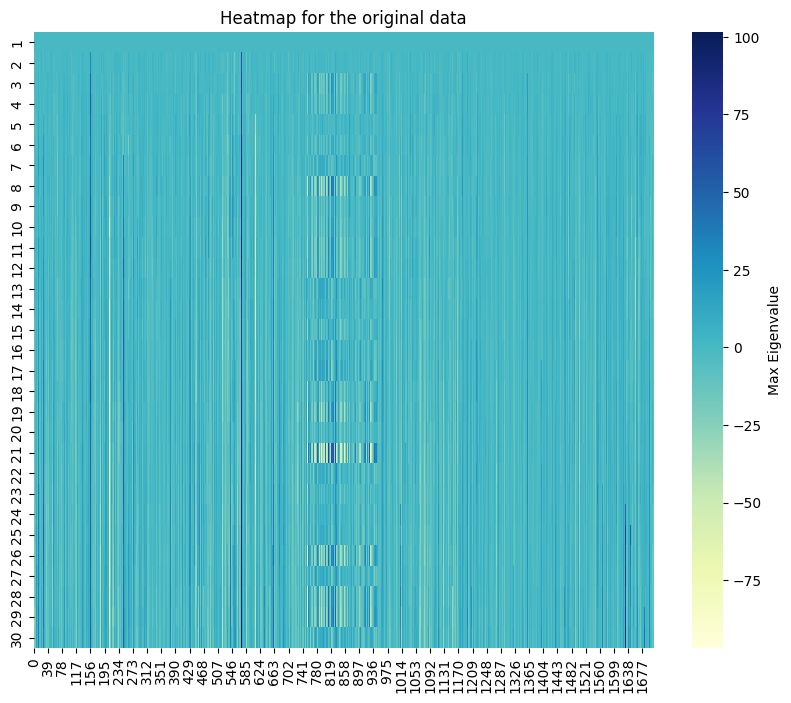

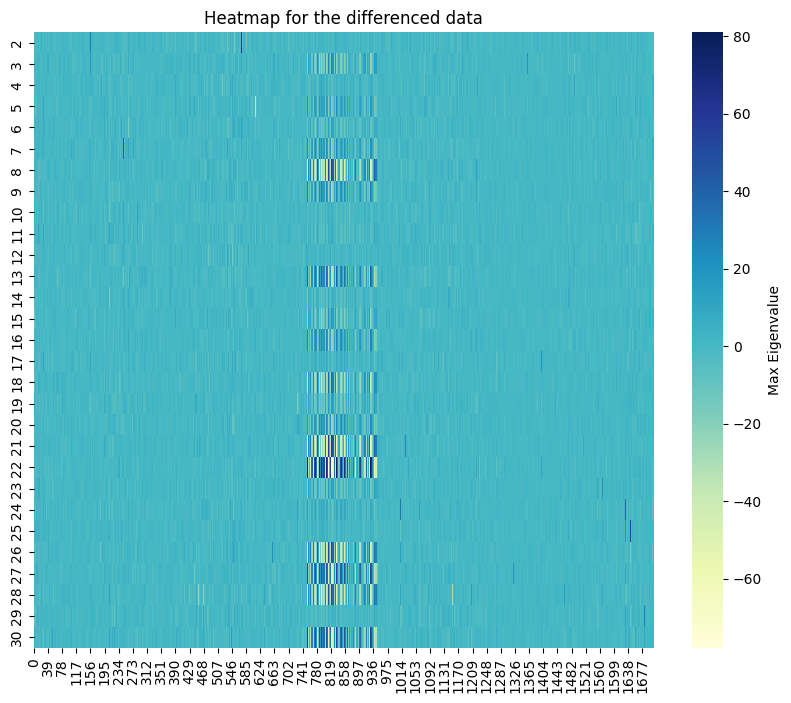

In [ ]:
pdata_diff_df = pd.DataFrame(pdata_diff)
pdata_df = pd.DataFrame(pdata)

# Plotting heatmaps for both original and differenced data.
plt.figure(figsize=(10, 8))
sns.heatmap(pdata_df.T, cmap="YlGnBu", cbar_kws={'label': 'Max Eigenvalue'})
plt.title("Heatmap for the original data")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(pdata_diff_df.T, cmap="YlGnBu", cbar_kws={'label': 'Max Eigenvalue'})
plt.title("Heatmap for the differenced data")
plt.show()

## Random Walk Plots
We expect to see random walks in minute-by-minute price changes for the unpolluted data

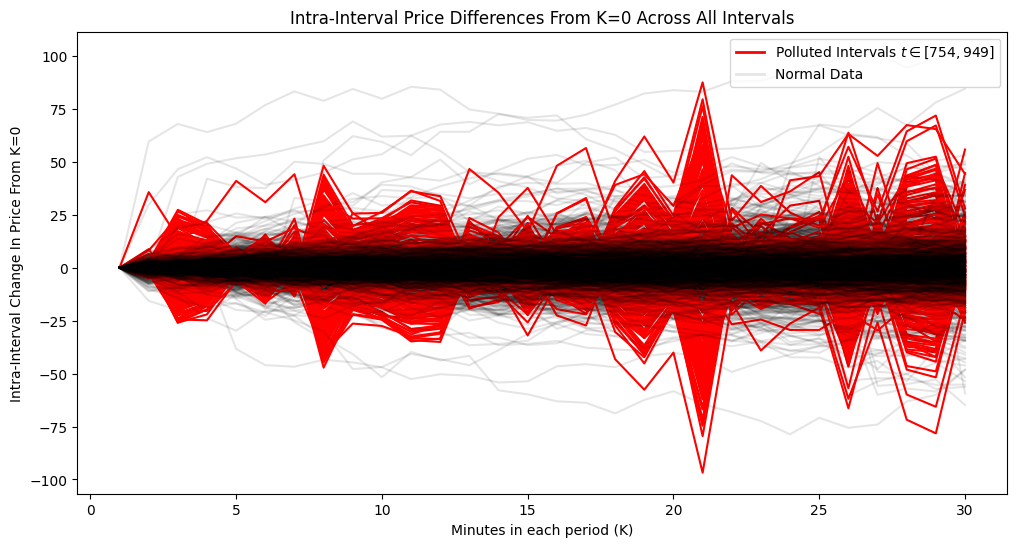

In [ ]:
plt.figure(figsize=(12, 6))

for row in range(0, 1700):
    if 754 <= row <= 949:  # Our final estimated polluted interval
        plt.plot(pdata.columns, pdata.iloc[row], color='red', alpha=1.0)
    else:
        plt.plot(pdata.columns, pdata.iloc[row], color='black', alpha=0.1)

legend_elements = [
    Line2D([0], [0], color='red', lw=2, label=f'Polluted Intervals $t\in[754,949]$'),  # Red line for the specified interval
    Line2D([0], [0], color='black', lw=2, alpha=0.1, label=f'Normal Data'), # Black line for the rest
]

plt.legend(handles=legend_elements, loc='upper right')
plt.xlabel("Minutes in each period (K)")
plt.ylabel(f'Intra-Interval Change In Price From K=0')
plt.title("Intra-Interval Price Differences From K=0 Across All Intervals")
plt.show()


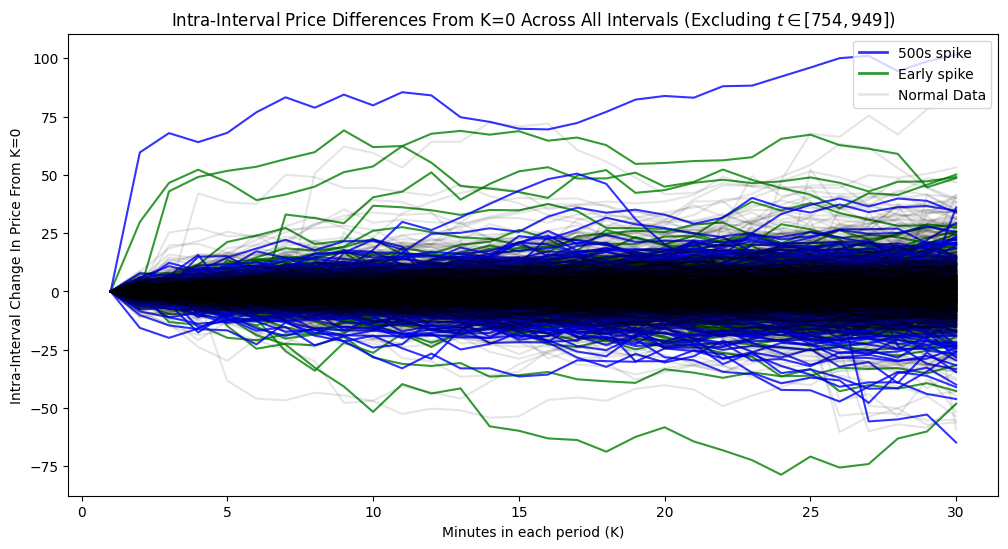

In [ ]:
plt.figure(figsize=(12, 6))

for row in range(0, 1700):
    if 754 <= row <= 949: continue #ignore our selected polluted data interval
    #displaying other high eigenvalue areas for comparison
    elif 440 <= row <= 575:
        plt.plot(pdata.columns, pdata.iloc[row], color='blue', alpha=0.8)
    elif 50 <= row <= 250:
        plt.plot(pdata.columns, pdata.iloc[row], color='green', alpha=0.8)
    else:
        plt.plot(pdata.columns, pdata.iloc[row], color='black', alpha=0.1)

legend_elements = [
    Line2D([0], [0], color='blue', lw=2, alpha=0.8, label='500s spike'),    # Blue for spike between 440 and 575
    Line2D([0], [0], color='green', lw=2, alpha=0.8, label='Early spike'),  # Green for spike at start of intervals
    Line2D([0], [0], color='black', lw=2, alpha=0.1, label='Normal Data')   # Black line for the rest
]

plt.legend(handles=legend_elements, loc='upper right')
plt.xlabel("Minutes in each period (K)")
plt.ylabel(f'Intra-Interval Change In Price From K=0')
plt.title(f'Intra-Interval Price Differences From K=0 Across All Intervals (Excluding $t\in[754,949]$)')
plt.show()
